In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

### Data Description
**survival:** Survival	0 = No, 1 = Yes<br>
**pclass:** Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd<br>
**sex:** Sex	<br>
** Age:** Age in years	<br>
** sibsp:** # of siblings / spouses aboard the Titanic	<br>
** parch:** # of parents / children aboard the Titanic	<br>
** ticket:** Ticket number	<br>
** fare:** Passenger fare	<br>
** cabin:** Cabin number	<br>
** embarked:** Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton<br>

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
gender_submission=pd.read_csv('gender_submission.csv')

In [3]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
continous_columns=['Age','SibSp','Parch','Fare']
category_columns=['Pclass','Embarked']

In [5]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 合併train test 

In [7]:
train=train.reset_index()
train['index']='train'+train['index'].astype(str)
test=test.reset_index()
test['index']='test'+test['index'].astype(str)

In [8]:
combine=train.append(test,sort=True).reset_index(drop=True)

In [9]:
combine.shape

(1309, 13)

#### 票價
找出票價與哪項特徵的相關係數最高

In [10]:
combine.corr()['Fare']

Age            0.178740
Fare           1.000000
Parch          0.221539
PassengerId    0.031428
Pclass        -0.558629
SibSp          0.160238
Survived       0.257307
Name: Fare, dtype: float64

In [11]:
combine[combine.Fare.isnull()]
##Ticket==3701

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,index
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,test152


依照Pclass來區分，Fare的遺漏值用中位數填充，平均數易受最大最小值影響，而中位數代表的數值相對較明確

In [12]:
Pclass=combine[combine.Ticket=='3701'].Pclass.values[0]
combine['Fare']=combine['Fare'].fillna(combine[combine.Pclass==Pclass]['Fare'].median())

#### Embarked
Embarked 依照 Ticket號碼 或 Cabin 前後排序皆為 S

In [13]:
combine[~combine.Cabin.isnull()&combine.Cabin.str.contains('B')].sort_values('Cabin')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,index
1057,48.0,B10,C,50.4958,"Brandeis, Mr. Emil",0,1058,1,male,0,NaN,PC 17591,test166
737,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,738,1,male,0,1.0,PC 17755,train737
815,NaN,B102,S,0.0000,"Fry, Mr. Richard",0,816,1,male,0,0.0,112058,train815
1106,42.0,B11,S,42.5000,"Head, Mr. Christopher",0,1107,1,male,0,NaN,113038,test215
523,44.0,B18,C,57.9792,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",1,524,1,female,0,1.0,111361,train523
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,40.0,B94,S,0.0000,"Harrison, Mr. William",0,264,1,male,0,0.0,112059,train263
763,36.0,B96 B98,S,120.0000,"Carter, Mrs. William Ernest (Lucile Polk)",2,764,1,female,1,1.0,113760,train763
390,36.0,B96 B98,S,120.0000,"Carter, Mr. William Ernest",2,391,1,male,1,1.0,113760,train390
802,11.0,B96 B98,S,120.0000,"Carter, Master. William Thornton II",2,803,1,male,1,1.0,113760,train802


In [14]:
combine['Embarked']=combine['Embarked'].fillna('S')

**特殊title** 
* Jonkheer:貴族頭銜
* the Countess:伯爵夫人
* Major:少校
* Master: 少爺
* Col:上校
* Rev:牧師
* Mlle:未婚女性(法)
* Mme:夫人(Madame)
* Don:貴族尊稱男性
* Dona:貴族尊稱女性
* Capt:船長

In [15]:
def findtitle(x):
    title=x[x.find(',')+1:x.find('.')].strip()
    for string in ['Mlle','Miss','Ms']:
        if title==string:
            title='Miss'
    for string in ['Mrs','Mme']:
        if title==string:
            title='Mrs'
    for string in ['Don','Jonkheer','Sir','the Countess','Dona','Lady']:
        if title==string:
            title='Royalty'
    for string in ['Capt','Col','Major','Dr','Rev']:
        if title==string:
            title='Others'
    return title
combine['title']=combine['Name'].apply(findtitle)

In [16]:
def findName(x):
    FirstName=x[:x.find(',')].strip()
    if x.find('Mr')>0:
        x=x[x.find('Mr'):].replace('")','')
        if x.find('(')>0:
            x=x[:x.find('(')].strip()
    if x.find('Mrs')>0:
        x=x[x.find('Mrs'):].replace('")','')
        if x.find('(')>0:
            x=x[:x.find('(')].strip()
    for string in ['Mrs.','Mrs','Dona.','Mme.','the Countess. of (']:
        if string in x:
            x=x.replace(string,'Mrs.').replace(')','')
            if x.find('"')!=-1:
                x=x[x.find("Mrs."):x.find('"')]
            else:
                x=x[x.find("Mrs."):]
            break
            break
    for string_ in ['Ms','Mlle','Miss.']:
        if string_ in x:
            x=x.replace(string_,'Miss.').replace(')','')
            if x.find('"')!=-1:
                x=x[x.find("Miss."):x.find('"')]
            else:
                x=x[x.find("Miss."):]
            break
    for string in ['Mr.','Mr ','Don.', 'Rev.', 'Dr.', 'Major.', 'Sir.','Col.', 'Capt.', 'Jonkheer.']:
        if string in x:
            x=x.replace(string,'Mr.').replace(')','')
            if x.find('"')!=-1:
                x=x[x.find("Mr."):x.find('"')]
            else:
                x=x[x.find("Mr."):]
            break
    if 'Master.' in x:
        x=x[x.find("Master."):x.find('"')]
        
    return(FirstName+','+x.strip())
combine['Name_adj']=combine['Name'].apply(findName)

In [17]:
combine.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Others'], dtype=object)

#### 年齡
用姓名(已婚未婚)來區分年齡，並用姓名的相似度來找尋夫妻

In [18]:
import difflib
find_couple=combine[(combine.SibSp>=1)&(combine.title!='Master')].sort_values(['Name_adj','Ticket','Cabin','Embarked']).reset_index(drop=True)
def string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).quick_ratio()
def similarity(x):
    gender=x[x.find(','):x.find('.')]
    most_similar=0
    for name  in list(find_couple['Name_adj']):
        if name!=x:
            if most_similar < string_similar(x,name):
                most_similar=string_similar(x,name)
                similar_name=name
    similar_gender=similar_name[similar_name.find(','):similar_name.find('.')]
    if gender!=similar_gender:
        return most_similar,similar_name
find_couple['couple_name']=find_couple['Name_adj'].apply(similarity)
find_couple[['similarity','couple_name']]=pd.DataFrame(find_couple['couple_name'].tolist(), index=find_couple.index)          

In [19]:
def check_name(x):
    couple_name=x['couple_name']
    if x['couple_onboard']==0:
        couple_name=None
    return couple_name
find_couple['couple_onboard']=find_couple['similarity'].apply(lambda x:1 if x>0.9 else 0)
find_couple['couple_name']=find_couple.apply(check_name,axis=1)

In [21]:
find_couple[['PassengerId','Name_adj','couple_onboard','couple_name']]

,PassengerId,Name_adj,couple_onboard,couple_name
0,747,"Abbott,Mr. Rossmore Edward",0,None
1,280,"Abbott,Mrs. Stanton",0,None
2,309,"Abelson,Mr. Samuel",1,"Abelson,Mrs. Samuel"
3,875,"Abelson,Mrs. Samuel",1,"Abelson,Mr. Samuel"
4,41,"Ahlin,Mrs. Johan",0,None
...,...,...,...,...
365,241,"Zabour,Miss. Thamine",0,None
366,1152,"de Messemaeker,Mr. Guillaume Joseph",1,"de Messemaeker,Mrs. Guillaume Joseph"
367,560,"de Messemaeker,Mrs. Guillaume Joseph",1,"de Messemaeker,Mr. Guillaume Joseph"
368,362,"del Carlo,Mr. Sebastiano",1,"del Carlo,Mrs. Sebastiano"


#### 根據婚姻狀況來說，結婚的乘客年紀較大，用中位數來填補空值

In [22]:
combine=combine.merge(find_couple[['PassengerId','Name_adj','couple_onboard','couple_name']],how='left')
combine['couple_onboard']=combine['couple_onboard'].fillna(0)

In [23]:
combine.groupby(['couple_onboard','Sex'])['Age'].median()

couple_onboard  Sex   
0.0             female    24.5
                male      27.0
1.0             female    33.5
                male      37.5
Name: Age, dtype: float64

In [24]:
combine.loc[(combine.couple_onboard==1)&(combine.Sex=='male'),'Age']=combine.loc[(combine.couple_onboard==1)&(combine.Sex=='male'),'Age'].fillna(37.5)
combine.loc[(combine.couple_onboard==1)&(combine.Sex=='female'),'Age']=combine.loc[(combine.couple_onboard==1)&(combine.Sex=='female'),'Age'].fillna(33.5)

combine.loc[(combine.couple_onboard==0)&(combine.Sex=='male'),'Age']=combine.loc[(combine.couple_onboard==0)&(combine.Sex=='male'),'Age'].fillna(27.0)
combine.loc[(combine.couple_onboard==0)&(combine.Sex=='female'),'Age']=combine.loc[(combine.couple_onboard==0)&(combine.Sex=='female'),'Age'].fillna(24.5)

# Feature Engineering
#### 同號船票

In [25]:
Ticket=combine['Ticket'].value_counts().to_frame(name='Ticket_count').reset_index().rename(columns={'index':'Ticket'})
combine=combine.merge(Ticket,how='left')

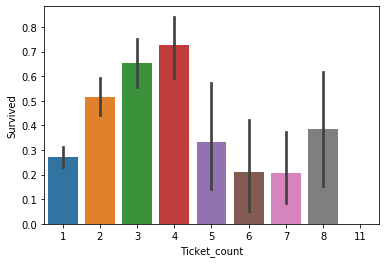

In [26]:
sns.barplot(data=combine,x='Ticket_count',y='Survived')

In [27]:
def size(x):
    if x==1:
        return 1
    elif 4>=x>=2:
        return 2
    else:
        return 3
combine['Ticket_size']=combine['Ticket_count'].apply(size)

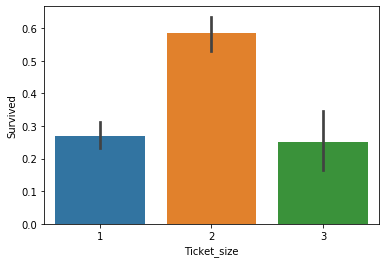

In [28]:
sns.barplot(data=combine,x='Ticket_size',y='Survived')

#### family-size

In [29]:
combine.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,index,title,Name_adj,couple_onboard,couple_name,Ticket_count,Ticket_size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train0,Mr,"Braund,Mr. Owen Harris",0.0,None,1,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train1,Mrs,"Cumings,Mrs. John Bradley",1.0,"Cumings,Mr. John Bradley",2,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train2,Miss,"Heikkinen,Miss. Laina",0.0,NaN,1,1


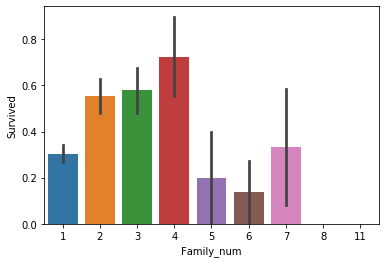

In [30]:
combine['Family_num']=combine['SibSp']+combine['Parch']+1
sns.barplot(data=combine,x='Family_num',y='Survived')

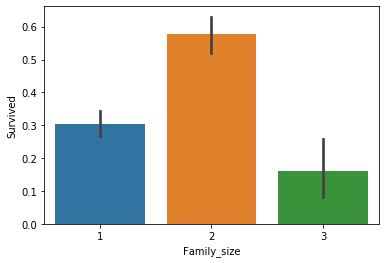

In [31]:
combine['Family_size']=combine['Family_num'].apply(size)
sns.barplot(data=combine,x='Family_size',y='Survived')

#### couple_survived

In [32]:
couple_table=combine[['Name_adj','Survived']]
couple_table.columns=['couple_name','couple_survived']

In [33]:
combine=combine.merge(couple_table,how='left')

In [34]:
combine['couple_survived']=combine['couple_survived'].fillna('U')

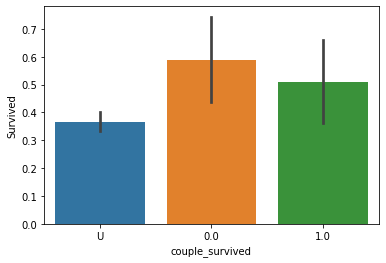

In [35]:
sns.barplot(data=combine,x='couple_survived',y='Survived')

#### Age
14~25 : 1<br>
26~35 : 2<br>
36~45 : 3<br>
46~   : 4

In [36]:
labels=[i for i in range(1,6)]
combine['Age_cut']=pd.cut(x=combine.Age,bins=[0,15,24,28,38,max(combine.Age)+1],labels=labels)

In [37]:
combine.Age_cut.value_counts()

3    373
2    293
5    266
4    262
1    115
Name: Age_cut, dtype: int64

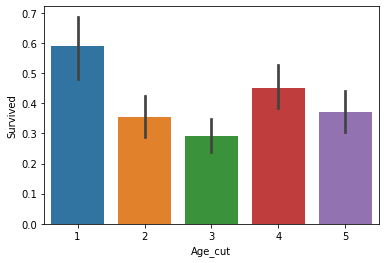

In [38]:
sns.barplot(data=combine,x='Age_cut',y='Survived')

#### 同家族存活率

In [39]:
combine['First_name']=combine['Name_adj'].apply(lambda x:x.split(',')[0].strip())

In [40]:
combine.First_name.value_counts()

Andersson     11
Sage          11
Goodwin        8
Asplund        8
Davies         7
              ..
Mernagh        1
Sheerlinck     1
Bracken        1
Shorney        1
Potter         1
Name: First_name, Length: 875, dtype: int64

#### 相同First_name 票號會相同

In [41]:
combine[combine.First_name=='Sage']['Ticket'].value_counts()

CA. 2343    11
Name: Ticket, dtype: int64

In [42]:
family_table=combine[(combine.First_name.isin(list(combine.First_name.value_counts().index)))&(combine.Ticket_count>3)]

In [43]:
First_name_table=family_table[['First_name','Ticket_count']].drop_duplicates(['First_name','Ticket_count'])
First_name_table=First_name_table.set_index('First_name')

**計算同船家人的存活率**

In [44]:
First_name_table['Family_survived_rate']=family_table.groupby('First_name').Survived.sum()/family_table.groupby('First_name').Survived.count()

In [45]:
First_name_table=First_name_table.reset_index()

In [46]:
combine=combine.merge(First_name_table,on=['First_name','Ticket_count'],how='left')

In [47]:
combine['Family_survived_rate']=combine['Family_survived_rate'].fillna('NaN')

In [48]:
def categorical(x):
    if x!='NaN':
        if x==0:
            x=0
        elif 0.5>=x>0:
            x=1
        else:
            x=2
    return x
combine.Family_survived_rate=combine.Family_survived_rate.apply(categorical)

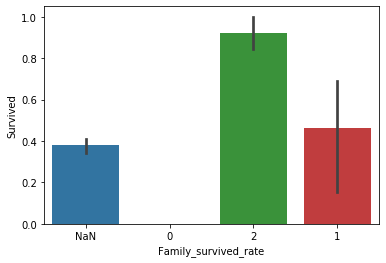

In [49]:
sns.barplot(data=combine,x='Family_survived_rate',y='Survived')

# Model Building

In [50]:
categorical=['Embarked','Pclass','Sex','title', 'couple_onboard','Ticket_size','Family_size','couple_survived','Age_cut', 'Family_survived_rate','Survived'] 
continuous=['Fare','Parch','SibSp','Ticket_count','Family_num']


In [51]:
for col in categorical:
    combine[col] = combine[col].astype("category").cat.codes

In [53]:
## train_test_split
train_ori=combine[combine["index"].str.contains('train')].drop(columns=['index','Age', 'Cabin','Name','Ticket','Name_adj','couple_name','First_name']).set_index('PassengerId')
test_ori=combine[combine["index"].str.contains('test')].drop(columns=['index','Age', 'Cabin','Name','Ticket','Name_adj','couple_name','First_name']).set_index('PassengerId')
y=train_ori[['Survived']]
x=train_ori[categorical+continuous].drop(columns='Survived')
output_x_ori=test_ori[categorical+continuous].drop(columns='Survived')
x_train_ori, x_test_ori, y_train, y_test = train_test_split(x, y,
                                                random_state=10, test_size=0.25)

**將連續型數值標準化**

In [56]:
from sklearn.preprocessing import StandardScaler
train=combine[combine["index"].str.contains('train')].drop(columns=['index','Age', 'Cabin','Name','Ticket','Name_adj','couple_name','First_name']).set_index('PassengerId')
test=combine[combine["index"].str.contains('test')].drop(columns=['index','Age', 'Cabin','Name','Ticket','Name_adj','couple_name','First_name']).set_index('PassengerId')
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(train[continuous]),columns =continuous).set_index(train.index)
df_scaled_test = pd.DataFrame(scaler.fit_transform(test[continuous]),columns =continuous).set_index(test.index)
train_std=pd.concat([train[categorical],df_scaled],axis=1)
test_std=pd.concat([test[categorical],df_scaled_test],axis=1)
y=train_std[['Survived']]
x=train_std[categorical+continuous].drop(columns='Survived')
output_x_std=test_std[categorical+continuous].drop(columns='Survived')
x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(x, y,
                                                random_state=10, test_size=0.25)

In [57]:
def builtmodel(model,param,x_train,x_test,output_x):
    grid_search = GridSearchCV(model, param_grid=param, cv = 3, scoring="roc_auc",
                                   verbose=10, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return (grid_search,grid_search.predict(output_x).astype(int))

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
        metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

In [58]:
output=pd.DataFrame()

In [59]:
import xgboost as xgb
from sklearn import metrics
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.model_selection import GridSearchCV


model = xgb.XGBClassifier()
param_dist = {"max_depth": [2,5,10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [50,100,200,300,400,500,600],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search_xgb_ori,output['XGB_ori']= builtmodel(model,param_dist,x_train_ori,x_test_ori,output_x_ori)
grid_search_xgb_std,output['XGB_std']= builtmodel(model,param_dist,x_train_std,x_test_std,output_x_std)

Fitting 3 folds for each of 315 candidates, totalling 945 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Fitting 3 folds for each of 315 candidates, totalling 945 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [60]:
import catboost as cb
cat_features_index = [0,1,2,3,4,5,6,7,8,9]

cb_model = cb.CatBoostClassifier()

param_dist = {'depth': [3,6,8,10],
           'learning_rate' : [0.1, 0.15,0.5,0.8],
          'l2_leaf_reg': [1,4,8],
          'iterations': [10,50,100],
           'one_hot_max_size':[5,8,10,15]}


grid_search_cat_ori,output['cat_ori']= builtmodel(cb_model,param_dist,x_train_ori,x_test_ori,output_x_ori)
grid_search_cat_std,output['cat_std']= builtmodel(cb_model,param_dist,x_train_std,x_test_std,output_x_std)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1966s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 324 ta

0:	learn: 0.6545354	total: 52.9ms	remaining: 5.24s
1:	learn: 0.6217608	total: 54.9ms	remaining: 2.69s
2:	learn: 0.5972232	total: 56.5ms	remaining: 1.83s
3:	learn: 0.5748267	total: 58ms	remaining: 1.39s
4:	learn: 0.5572637	total: 59.4ms	remaining: 1.13s
5:	learn: 0.5401510	total: 60.8ms	remaining: 953ms
6:	learn: 0.5261711	total: 62.3ms	remaining: 828ms
7:	learn: 0.5150544	total: 63.7ms	remaining: 733ms
8:	learn: 0.5033830	total: 65ms	remaining: 658ms
9:	learn: 0.4924512	total: 66.4ms	remaining: 598ms
10:	learn: 0.4839327	total: 67.7ms	remaining: 548ms
11:	learn: 0.4770040	total: 69.1ms	remaining: 506ms
12:	learn: 0.4691104	total: 70.4ms	remaining: 471ms
13:	learn: 0.4616937	total: 71.8ms	remaining: 441ms
14:	learn: 0.4579194	total: 73.1ms	remaining: 414ms
15:	learn: 0.4530764	total: 75.9ms	remaining: 398ms
16:	learn: 0.4476345	total: 78.3ms	remaining: 382ms
17:	learn: 0.4429763	total: 80.6ms	remaining: 367ms
18:	learn: 0.4402542	total: 81.8ms	remaining: 349ms
19:	learn: 0.4377353	total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1991s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1978s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    4.5s
[Parallel(n_j

0:	learn: 0.6545354	total: 345us	remaining: 34.2ms
1:	learn: 0.6217608	total: 706us	remaining: 34.6ms
2:	learn: 0.5972232	total: 985us	remaining: 31.9ms
3:	learn: 0.5748267	total: 1.27ms	remaining: 30.6ms
4:	learn: 0.5572637	total: 1.56ms	remaining: 29.6ms
5:	learn: 0.5401510	total: 1.84ms	remaining: 28.8ms
6:	learn: 0.5261711	total: 2.12ms	remaining: 28.1ms
7:	learn: 0.5150544	total: 2.4ms	remaining: 27.7ms
8:	learn: 0.5033830	total: 2.64ms	remaining: 26.7ms
9:	learn: 0.4924512	total: 2.88ms	remaining: 25.9ms
10:	learn: 0.4839327	total: 3.12ms	remaining: 25.2ms
11:	learn: 0.4770040	total: 3.35ms	remaining: 24.6ms
12:	learn: 0.4691104	total: 3.59ms	remaining: 24ms
13:	learn: 0.4616937	total: 3.82ms	remaining: 23.5ms
14:	learn: 0.4579194	total: 4.05ms	remaining: 22.9ms
15:	learn: 0.4530764	total: 4.29ms	remaining: 22.6ms
16:	learn: 0.4476345	total: 4.53ms	remaining: 22.1ms
17:	learn: 0.4429763	total: 4.78ms	remaining: 21.8ms
18:	learn: 0.4402542	total: 5.01ms	remaining: 21.3ms
19:	learn

[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:   38.0s finished


In [61]:
import lightgbm as lgb

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))

model = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [3,5,10,25],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200,300,400,500]
             }

grid_search_lgb_ori,output['lgb_ori']= builtmodel(model,param_dist,x_train_ori,x_test_ori,output_x_ori)
grid_search_lgb_std,output['lgb_std']= builtmodel(model,param_dist,x_train_std,x_test_std,output_x_std)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1962s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 212 ta

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 210 ta

In [62]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
param_dist = {"penalty": ['l2'],
              "tol" : [0.001,0.01,0.05,0.1],
              "C": [0.01,0.1,0.3,0.7,1.0],
              "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              "max_iter":[50,150,100,200,300]}

grid_search_LR_ori,output['LR_ori']= builtmodel(model,param_dist,x_train_ori,x_test_ori,output_x_ori)
grid_search_LR_std,output['LR_std']= builtmodel(model,param_dist,x_train_std,x_test_std,output_x_std)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1939s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0676s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0790s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1852s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0660s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0771s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0

### Stacking

In [83]:
print(f'LR_ori:{auc(grid_search_LR_ori,x_train_ori, x_test_ori)}')
print(f'LR_std:{auc(grid_search_LR_std,x_train_std, x_test_std)}')

print(f'CatB_ori:{auc(grid_search_cat_ori,x_train_ori, x_test_ori)}')
print(f'CatB_std:{auc(grid_search_cat_std,x_train_std, x_test_std)}')

print(f'XGB_ori:{auc(grid_search_xgb_ori,x_train_ori, x_test_ori)}')
print(f'XGB_std:{auc(grid_search_xgb_std,x_train_std, x_test_std)}')

print(f'LGB_ori:{auc2(grid_search_lgb_ori,x_train_ori, x_test_ori)}')
print(f'LGB_std:{auc2(grid_search_lgb_std,x_train_std, x_test_std)}')

LR_ori:(0.8817472786443722, 0.8612602935911208)
LR_std:(0.8813358021920472, 0.8609022556390977)
CatB_ori:(0.9112333071484682, 0.9058807733619764)
CatB_std:(0.9112333071484682, 0.9058807733619764)
XGB_ori:(0.907501963864886, 0.9233798782670963)
XGB_std:(0.907501963864886, 0.9233798782670963)
LGB_ori:(0.8480529682414993, 0.8341836734693878)
LGB_std:(0.8492967493360266, 0.8341836734693878)


In [80]:
LR_test_ori=grid_search_LR_ori.predict(x_test_ori)
LR_test_std=grid_search_LR_std.predict(x_test_std)
lgb_test_ori=grid_search_lgb_ori.predict(x_test_ori)
lgb_test_std=grid_search_lgb_std.predict(x_test_std)
cat_test_ori=grid_search_cat_ori.predict(x_test_ori)
cat_test_std=grid_search_cat_std.predict(x_test_std)
xgb_test_ori=grid_search_xgb_ori.predict(x_test_ori)
xgb_test_std=grid_search_xgb_std.predict(x_test_std)

In [81]:
first_x=np.transpose(np.vstack([xgb_test_std,cat_test_std,lgb_test_std,LR_test_std]))
first_y=y_test
model = LogisticRegression()
model.fit(first_x, first_y)
gender_submission=pd.read_csv("gender_submission.csv")
gender_submission['Survived']=model.predict(output[['XGB_std','cat_std','lgb_std','LR_std']])
gender_submission['Survived']=gender_submission['Survived'].astype(int)
gender_submission.to_csv('stacking_ori.csv',index=False)

/home/jim/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jim/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Best Score(AUC):0.80382**<br>
**Public Ranking: 1343/15902 (TOP 9%)**